In [1]:
import numpy as np
import sys,os
module_root = '..'
sys.path.append(module_root)
from settings import raw_folder
import glob
import seaborn as sns
import SimpleITK as sitk
import pandas as pd

In [2]:
tifs = sorted(glob.glob(raw_folder + '/*.tif'))
print('no of tifs: {}'.format(len(tifs)))

no of tifs: 1


In [3]:
image_index = 0
tif_path = tifs[image_index]
image = sitk.ReadImage(tif_path)
nda = sitk.GetArrayFromImage(image)

In [4]:
labels = sorted(glob.glob(raw_folder + '/' + os.path.basename(tif_path).split('.')[0] + '_label_*.nrrd'))
print('no of labels: {}'.format(len(labels)))

no of labels: 2


In [5]:
label_index = 1
label_path = labels[label_index]
label = sitk.ReadImage(label_path)
label_nda = sitk.GetArrayFromImage(label).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)

In [6]:
print(label_path)
roi_path = label_path.replace('.nrrd', '_roi.acsv')

/home/mehrtash/dropbox/qanat/raw/DS1039-2088DA038_b_label_2.nrrd


In [7]:
roi = np.zeros((2,2))
i = 0
with open(roi_path) as f:
    for line in f.readlines():
        if line.startswith('point'):
            p = line.split('|')
            roi[i,0] = -float(p[1])
            roi[i,1] = -float(p[2])
            i += 1

In [8]:
center = list(roi[0])
center = np.asarray(image.TransformPhysicalPointToIndex(center))
spacing = image.GetSpacing()
length = np.abs(roi[1]/spacing).astype(np.int)
start = center - length
end = center + length
print(start,end)

[16202  7151] [18206  9155]


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

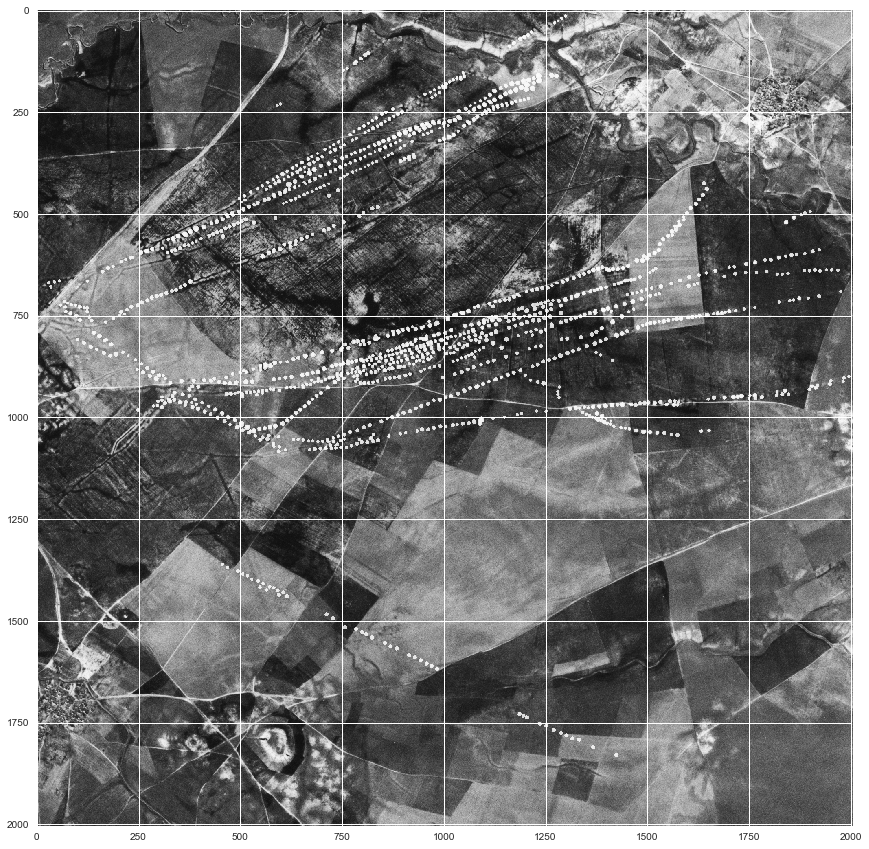

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(nda[start[1]:end[1], start[0]:end[0]], cmap=plt.cm.gray)
plt.imshow(label_mask[start[1]:end[1], start[0]:end[0]], alpha=0.8)

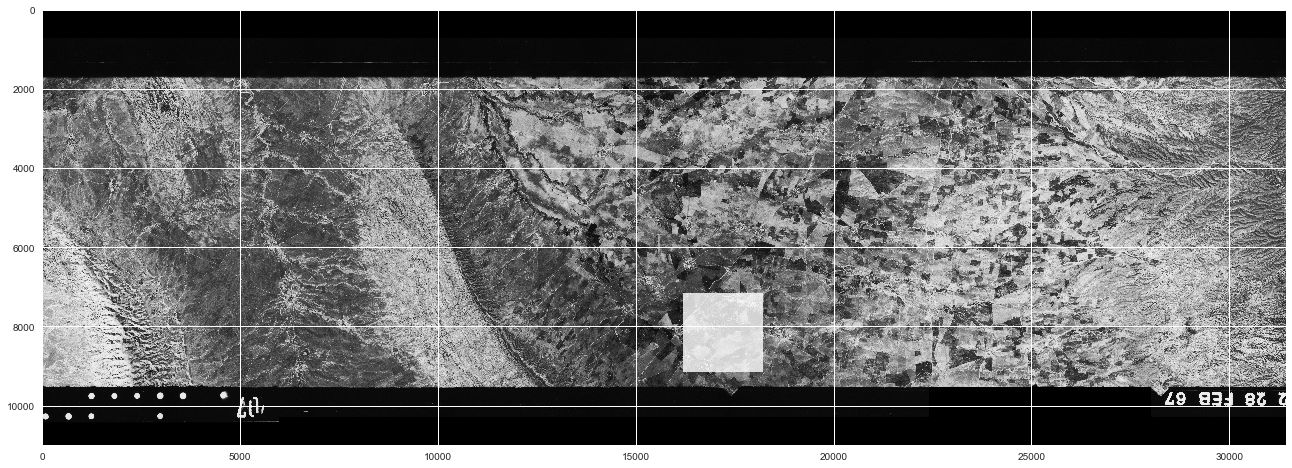

In [11]:
plt.figure(figsize=(24,8))
annotation_area = np.zeros_like(nda)
annotation_area[start[1]:end[1], start[0]:end[0]] = 255
annotation_area = np.ma.masked_where(annotation_area== 0, annotation_area)
plt.imshow(nda, cmap=plt.cm.gray)
plt.imshow(annotation_area, alpha=0.8)

In [12]:
ccf = sitk.ConnectedComponentImageFilter()
ccf.SetFullyConnected(True)
ccf_labelmap = ccf.Execute(label)
stats_filter = sitk.LabelStatisticsImageFilter()
stats_filter.Execute(ccf_labelmap, ccf_labelmap)
labels = list(stats_filter.GetLabels())
labels.remove(0)
print(len(labels))

1015


In [13]:
changeFilter = sitk.ChangeLabelImageFilter()
changeMap = sitk.DoubleDoubleMap()
for label_val in labels:
    changeMap[label_val] = int(np.random.randint(0,255,1)[0])
ccf_labelmap_random = changeFilter.Execute(ccf_labelmap, changeMap)

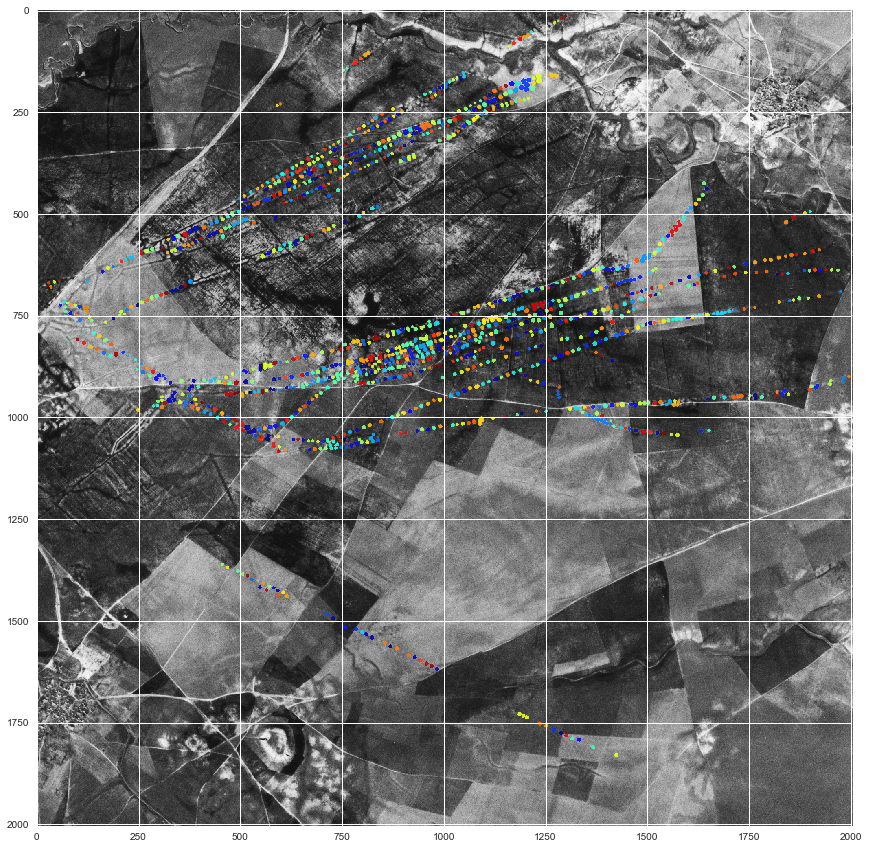

In [14]:
plt.figure(figsize=(15,15))
label_nda = sitk.GetArrayFromImage(ccf_labelmap_random).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)
plt.imshow(nda[start[1]:end[1], start[0]:end[0]], cmap=plt.cm.gray)
plt.imshow(label_mask[start[1]:end[1], start[0]:end[0]], alpha=0.9,cmap=plt.cm.jet)

In [15]:
d = []
pd.DataFrame(d)
for label_value in labels:
    bb = np.asarray(stats_filter.GetBoundingBox(label_value))
    d.append({'label': label_value, 'count': stats_filter.GetCount(label_value), 'x': int( bb[0] + (bb[1]-bb[0])/2), 
              'y': int(bb[2] + (bb[3]-bb[2])/2)}) 

In [16]:
df = pd.DataFrame(d)

In [17]:
largest = df.sort_values('count', ascending=False).head(25)
smallest = df.sort_values('count', ascending=True).head(25)
largest

count  label      x     y
20      617     21  17399  7334
480     604    481  17318  7911
882     467    883  17584  8157
425     463    426  17433  7876
719     447    720  16943  8054
260     426    261  17770  7686
15      387     16  17429  7318
908     374    909  16725  8180
85      367     86  17156  7435
307     364    308  17697  7759
799     362    800  16532  8101
360     339    361  17649  7816
258     318    259  16699  7671
594     307    595  17141  7990
581     289    582  17112  7971
677     287    678  16768  8024
457     287    458  17887  7893
812     280    813  17922  8099
588     252    589  17150  7979
574     250    575  16986  7967
556     245    557  17151  7955
888     240    889  17292  8160
898     238    899  16699  8170
273     236    274  16634  7700
1005    232   1006  17395  8883

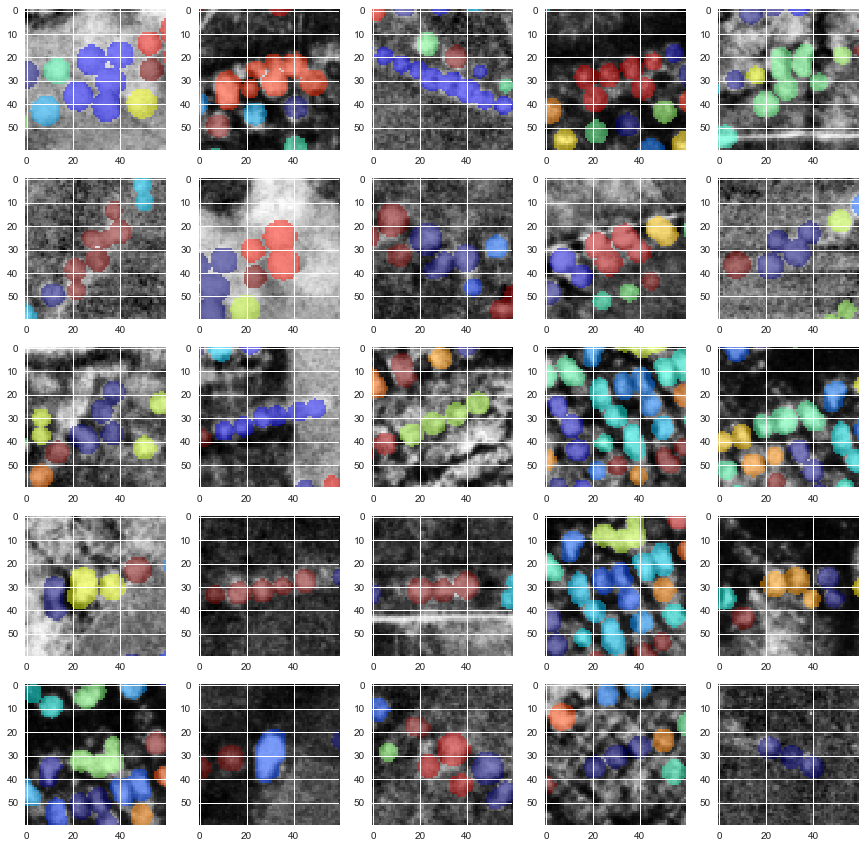

In [18]:
fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
pad = 30
axs = axs.ravel()
i = 0
for index, row in largest.iterrows():
    x = row['x']
    y = row['y']
    label_val = row['label']
    axs[i].imshow(nda[-pad+y:pad+y, -pad+x:pad+x], cmap=plt.cm.gray)
    axs[i].imshow(label_mask[-pad+y:pad+y, -pad+x:pad+x], alpha=0.5, cmap=plt.cm.jet)
    i +=1

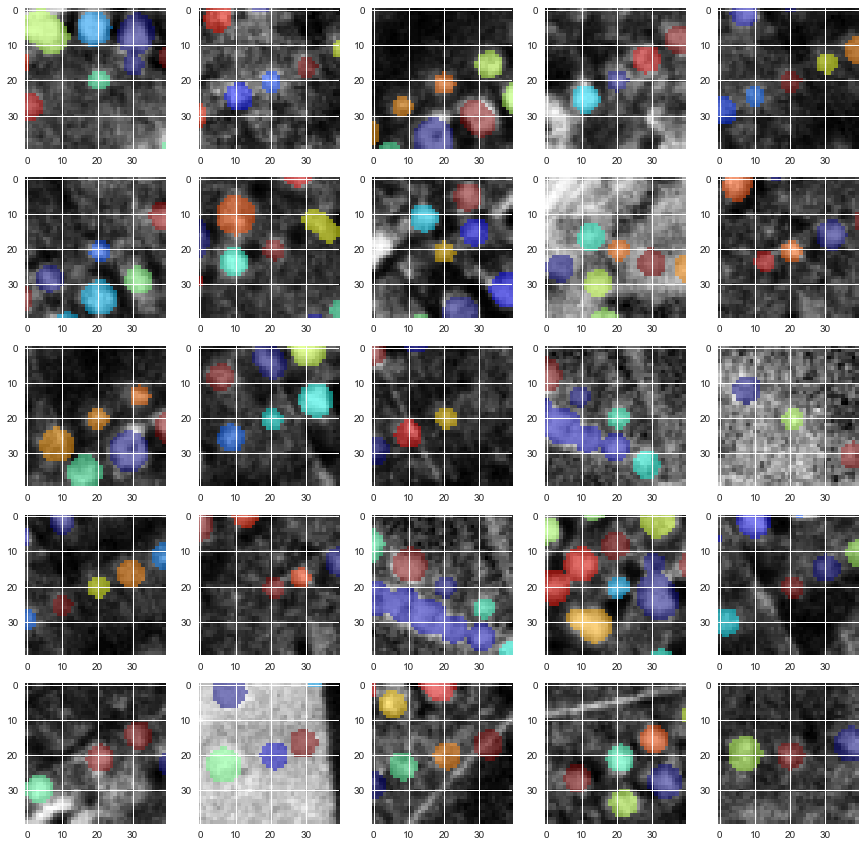

In [19]:
fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
pad = 20
axs = axs.ravel()
i = 0
for index, row in smallest.iterrows():
    x = row['x']
    y = row['y']
    label_val = row['label']
    axs[i].imshow(nda[-pad+y:pad+y, -pad+x:pad+x], cmap=plt.cm.gray)
    axs[i].imshow(label_mask[-pad+y:pad+y, -pad+x:pad+x], alpha=0.5, cmap=plt.cm.jet)
    i +=1

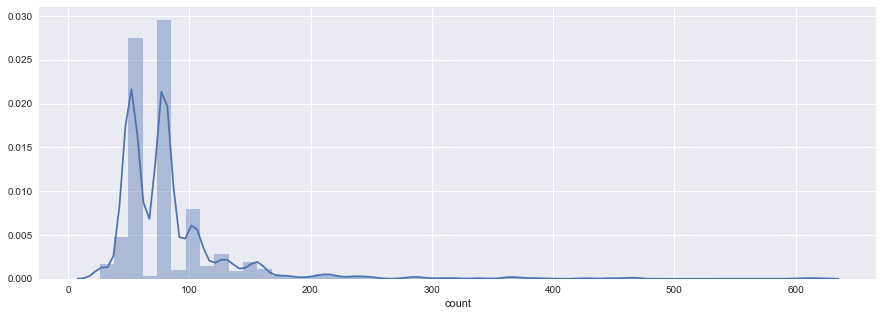

In [20]:
tmp_df = df[df.label != 618] # this is based on random ...
plt.figure(figsize=(15, 5))
sns.distplot(tmp_df['count'])

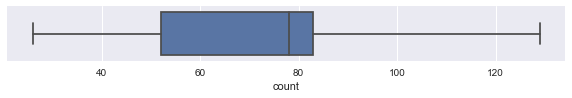

In [21]:
plt.figure(figsize=(10, 1))
sns.boxplot(df['count'],showfliers=False)

In [22]:
df[df.label != 1]

count  label      x     y
1        51      2  17490  7171
2        27      3  17482  7177
3        50      4  17473  7182
4        49      5  17415  7204
5       157      6  17403  7215
6        77      7  17388  7221
7        79      8  17372  7231
8        51      9  17362  7239
9       158     10  17011  7259
10       75     11  16997  7270
11      100     12  16983  7280
12       49     13  16963  7293
13       51     14  16954  7298
14      115     15  17249  7309
15      387     16  17429  7318
16      212     17  17471  7312
17       90     18  17242  7318
18       50     19  17232  7317
19       50     20  17223  7321
20      617     21  17399  7334
21       49     22  17215  7327
22      129     23  17368  7331
23      102     24  17382  7330
24       80     25  17422  7329
25      108     26  17206  7336
26       78     27  17353  7336
27      130     28  17193  7339
28       79     29  17340  7342
29      131     30  17418  7344
30      131     31  17377  7347
...     ...    ...    ...   ...
985      61    986  16793  8576
986      78    987  16806  8580
987      80    988  16795  8586
988      80    989  16815  8589
989      79    990  16912  8634
990      78    991  16928  8643
991      80    992  16958  8666
992      79    993  16984  8670
993      79    994  17000  8678
994      78    995  17009  8683
995      80    996  17024  8691
996      76    997  17056  8705
997      77    998  17069  8713
998      78    999  17084  8718
999      79   1000  17115  8734
1000     80   1001  17129  8740
1001     80   1002  17143  8747
1002     78   1003  17158  8755
1003     79   1004  17170  8761
1004     79   1005  17184  8768
1005    232   1006  17395  8883
1006     79   1007  17436  8903
1007     79   1008  17452  8908
1008     79   1009  17471  8918
1009     79   1010  17488  8926
1010     79   1011  17501  8931
1011     78   1012  17516  8939
1012     77   1013  17533  8942
1013     79   1014  17567  8961
1014     78   1015  17624  8979

[1014 rows x 4 columns]